<a href="https://colab.research.google.com/github/Kamal-Moha/Stroke_Prediction/blob/main/Over_Sampling_Modeling_Making_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, classification_report, recall_score

import warnings
warnings.filterwarnings('ignore')

In [53]:
file = '/content/drive/MyDrive/CODING DOJO DS BOOTCAMP/PROJECTS/PROJECT 2/Stroke Prediction Dataset/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(file)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [54]:
# get rid of the id column because its not much significant
df = df.drop(columns='id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [55]:
# Checking target balance
df['stroke'].value_counts(normalize=True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

We can clearly see that our dataset is not balanced. 95% of our people don't have a stroke.

We **MUST** fix this imbalance before Modeling as imbalanced data will affect our results. To fix this, I will over sample the 1 class in my stroke column

## **Over sampling**

In [56]:
# class count
class_count_0, class_count_1 = df['stroke'].value_counts()

# divide by class
df_class_0 = df[df['stroke'] == 0]
df_class_1 = df[df['stroke'] == 1]

In [57]:
# Over sampling the 1 class using the sample function
df_class_1_over = df_class_1.sample(class_count_0, replace=True)

# Now concating these 2 dataframes to get a new one
df_test_over = pd.concat([df_class_1_over, df_class_0])

In [58]:
# getting value_counts of stroke using df_test_over 
df_test_over.stroke.value_counts()

1    4861
0    4861
Name: stroke, dtype: int64

**Perfect**, We now have a well balanced dataframe `df_test_over` and can use it for Modeling

In [59]:
# checking for duplicates
df_test_over.duplicated().sum()

4612

In [60]:
# check missing values
df_test_over.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  980
smoking_status         0
stroke                 0
dtype: int64

**Handling missing values**

I will fill missing bmi with the median bmi of the gender assigned to that row

In [61]:
# grouping the data by gender and finding the median bmi of each gender
median_bmi = df_test_over.groupby('gender')['bmi'].transform('median')

# fill missing bmi with the median bmi of the gender type assinged to that row
df_test_over['bmi'] = df_test_over['bmi'].fillna(median_bmi)


In [62]:
df_test_over.isna().sum().sum()

0

**Split the data into Train & Test sets**

In [63]:
# target vector
y = df_test_over['stroke']

# Feaure matrix
X = df_test_over.drop(columns='stroke')

# train test split
# stratify just further balances the target vector
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## **Preprocessing**

In [22]:
# separating our data by column type
cat_selector = make_column_selector(dtype_include='object')

# Selecting specific columns 
# because I don't want to scale every numerical like hypertension & heart_disease
num_selector = ['age', 'avg_glucose_level', 'bmi']

In [23]:
# Instantiating the transformers
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [24]:
# Creating tuples for transformation
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

**Column Transformer**

In [25]:
# creating a column transformer to transform the data
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

In [26]:
# Fit the train data
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['age', 'avg_glucose_level', 'bmi']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f59c4b34c40>)])

In [27]:
# Transforming both the Train & Test sets
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)

In [28]:
# getting back the right column names after transformation
processed_names = col_transformer.get_feature_names_out()
actual_names = [i.split('__')[1] for i in processed_names]

In [29]:
# creating a dataframe using X_train_processed
X_train_df = pd.DataFrame(X_train_processed, columns=actual_names)
X_train_df.head()

,age,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease
0,1.209813,-1.074308,0.545783,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.136371,2.098933,2.810488,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.120067,-0.906316,-0.752456,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1.030321,-0.928934,-0.694756,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.087993,-0.926745,0.502508,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [30]:
# creating a dataframe using X_test_processed
X_test_df = pd.DataFrame(X_test_processed, columns=actual_names)
X_test_df.head()

,age,avg_glucose_level,bmi,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,...,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,hypertension,heart_disease
0,0.716212,1.381183,-1.012104,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.168444,-0.924009,-1.416000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-1.706918,-0.878956,-0.911129,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.841536,-0.616662,0.646757,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.222612,-0.379175,-0.435109,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## **Creating Models**

**Logistic Regression**

In [31]:
# instantiating the model
lreg = LogisticRegression()

# fit the train data
lreg.fit(X_train_df, y_train)

# Evaluate
print(lreg.score(X_train_df, y_train))
print(lreg.score(X_test_df, y_test))

0.7768481689754492
0.7778691896338955


**Hyperparameter tuning the Logisitic Regression**

In [32]:
# Find tunable parameters
lreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [33]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000], 
     'C': [-1, 0, 1, 10]
    }
]

In [34]:
# instantite GridSearchCV
lreg_grid_search = GridSearchCV(lreg, param_grid = param_grid, cv = 3, verbose=True)

# Fit on the train data
lreg_grid_search.fit(X_train_df, y_train)

Fitting 3 folds for each of 320 candidates, totalling 960 fits


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid=[{'C': [-1, 0, 1, 10],
                          'max_iter': [100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             verbose=True)

In [35]:
#retrieve the best version of the model
best_lreg = lreg_grid_search.best_estimator_

#refit the model on the whole training set
best_lreg.fit(X_train_df, y_train)

#  make predictions
best_lreg_preds = best_lreg.predict(X_test_df)

#score the model on the test set
print(f'Best Train Score: {best_lreg.score(X_train_df, y_train)}')
print(f'Best Test Score: {best_lreg.score(X_test_df, y_test)}')


Best Train Score: 0.7769853243725141
Best Test Score: 0.7778691896338955


In [36]:
# classification_report
print(classification_report(y_test, best_lreg_preds))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      1216
           1       0.75      0.82      0.79      1215

    accuracy                           0.78      2431
   macro avg       0.78      0.78      0.78      2431
weighted avg       0.78      0.78      0.78      2431



**KNN Model**

In [38]:
# instantiate the model
knn = KNeighborsClassifier()

# fit the train data
knn.fit(X_train_df, y_train)

# Evaluate
print(knn.score(X_train_df, y_train))
print(knn.score(X_test_df, y_test))



0.9489781922918666
0.9218428630193336


**Hyperparameter tuning the model**

In [39]:
# find tunable parameters
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [40]:
param_grid2 = [
    {'leaf_size': range(10, 50, 10),
     'n_jobs': [-1, 0, 1], 
     'n_neighbors': range(1, 5),
     'p': range(1, 4),
     'weights': ['uniform', 'distance']
        
    }
]

In [41]:
# instantiate GridSearch
knn_grid_search = GridSearchCV(knn, param_grid=param_grid2)

# Fit the data
knn_grid_search.fit(X_train_df, y_train)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid=[{'leaf_size': range(10, 50, 10), 'n_jobs': [-1, 0, 1],
                          'n_neighbors': range(1, 5), 'p': range(1, 4),
                          'weights': ['uniform', 'distance']}])

In [42]:
# retrieve the best version of the knn
best_knn = knn_grid_search.best_estimator_

# refit the model
best_knn.fit(X_train_df, y_train)

#  make predictions
best_knn_preds = best_knn.predict(X_test_df)

#Evaluate the model
print(f'Best Train Score: {best_knn.score(X_train_df, y_train)}')
print(f'Best Test Score: {best_knn.score(X_test_df, y_test)}')

Best Train Score: 1.0
Best Test Score: 0.9679144385026738


In [43]:
# classification_report
print(classification_report(y_test, best_knn_preds))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1216
           1       0.94      1.00      0.97      1215

    accuracy                           0.97      2431
   macro avg       0.97      0.97      0.97      2431
weighted avg       0.97      0.97      0.97      2431



**Decision Tree Model**

In [44]:
# instantiate the model
dec_tree = DecisionTreeClassifier()

# fit the data
dec_tree.fit(X_train_df, y_train)

# Evaluate the model
print(f'Train Score: {dec_tree.score(X_train_df, y_train)}')
print(f'Test Score: {dec_tree.score(X_test_df, y_test)}')

Train Score: 1.0
Test Score: 0.9716166186754422


**Hyperparameter tuning the model**

In [45]:
# find tunable parameters
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [46]:
param_grid3 = [
    {'max_depth': range(1, 12), 
     'splitter': ['best', 'random'],
     'random_state': [42],
     'max_features': [int, float, 'auto'],
     'min_samples_leaf': range(1, 5), 
     'criterion': ['gini', 'entropy', 'log_loss']
        
    }
]

In [47]:
# GridSearch
dec_tree_grid = GridSearchCV(dec_tree, param_grid3)

# Fit the model
dec_tree_grid.fit(X_train_df, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': range(1, 12),
                          'max_features': [<class 'int'>, <class 'float'>,
                                           'auto'],
                          'min_samples_leaf': range(1, 5), 'random_state': [42],
                          'splitter': ['best', 'random']}])

In [48]:
# retrieve the best model 
best_tree = dec_tree_grid.best_estimator_

# Fit using train data
best_tree.fit(X_train_df, y_train)

#  make predictions
best_tree_preds = best_tree.predict(X_test_df)

# Evaluate the model
print(f'Best Train Score: {best_tree.score(X_train_df, y_train)}')
print(f'Best Test Score: {best_tree.score(X_test_df, y_test)}')

Best Train Score: 0.9200384035111782
Best Test Score: 0.9090909090909091


In [49]:
# classification_report
print(classification_report(y_test, best_tree_preds))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90      1216
           1       0.86      0.98      0.91      1215

    accuracy                           0.91      2431
   macro avg       0.92      0.91      0.91      2431
weighted avg       0.92      0.91      0.91      2431



## **More Model(s) Evaluation**

Finding the AUC scores for each model and plotting the ROC Curves for each model. 

I will base my performance on the test data

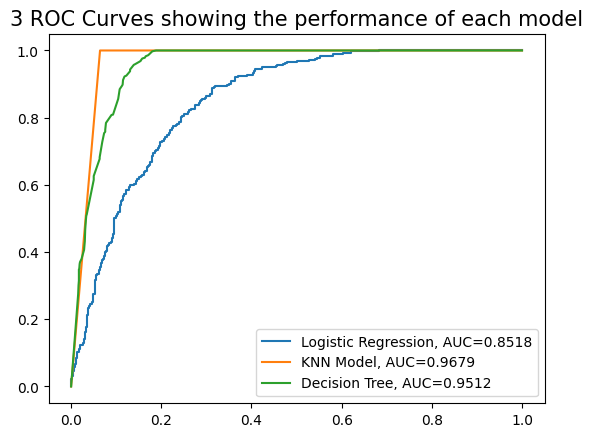

In [50]:
#set up plotting area
plt.figure(0).clf()

# plot ROC curve for the Logistic Regression
y_pred = best_lreg.predict_proba(X_test_df)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))

# plot ROC curve for the KNN Model
y_pred = best_knn.predict_proba(X_test_df)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN Model, AUC="+str(auc))

#plot ROC curve for the Decision Tree
y_pred = best_tree.predict_proba(X_test_df)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

# Create a Title 
plt.title('3 ROC Curves showing the performance of each model', fontsize=15)

#add legend
plt.legend()

As you can see from the above plot, the Logistic Regression Model has the highest AUC Score.

## **Choosing my "production" model and justifying the decision**

I have chosen the **KNeighbors(KNN) model** and here are my reasons.

1. The KNN model has the highest **Recall** score which is a very important metric to consider when making stroke predictions.
2. The KNN model has the highest AUC score which means that it is better at distinguishing between positive and negative instances across our dataset.
3. The KNN model also has the highest f1 score
4. The KNN model also has the highest overall accuracy score on the test set

**Resource Used:**

https://towardsdatascience.com/machine-learning-target-feature-label-imbalance-problem-and-solutions-98c5ae89ad0